In [ ]:
#Install Dependency
!pip install rfdetr supervision pycocotools matplotlib opencv-python roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 8.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00

In [ ]:
#import libraries
from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES
import torch
from PIL import Image
import supervision as sv
import os
import random
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from tqdm import tqdm
import albumentations as A

In [ ]:
#Upload Dataset
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="LB5Ol71zSPQuUklvsdQT")
project = rf.workspace("datasci-f3d5w").project("animals-ij5d2-nkoj2")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to animals-2 in coco:: 100%|██████████| 1008/1008 [00:00<00:00, 11245.14it/s]


In [ ]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 700
Number of validation images: 200
Number of test images: 100


In [ ]:
# Augmentation Steps
train_augmentation_and_transform = A.Compose(
    [
        A.Perspective(p=0.1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

In [ ]:
#start training
model = RFDETRMedium()

model.train(
    dataset_dir="/content/animals-2",
    epochs=10,  # continue for more
    batch_size=4,
    grad_accum_steps=8,
    lr=5e-5,
    output_dir="./rfdetr_output",

)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 11 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir ./rfdetr_output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=11, grad_accum_steps=8, amp=True, lr=5e-05, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=10, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, 

Test:  [ 0/50]  eta: 0:00:30  class_error: 50.00  loss: 8.9956 (8.9956)  loss_ce: 1.3906 (1.3906)  loss_bbox: 0.2578 (0.2578)  loss_giou: 0.1530 (0.1530)  loss_ce_0: 1.4375 (1.4375)  loss_bbox_0: 0.1883 (0.1883)  loss_giou_0: 0.0882 (0.0882)  loss_ce_1: 1.4062 (1.4062)  loss_bbox_1: 0.2766 (0.2766)  loss_giou_1: 0.1455 (0.1455)  loss_ce_2: 1.4219 (1.4219)  loss_bbox_2: 0.2030 (0.2030)  loss_giou_2: 0.1053 (0.1053)  loss_ce_enc: 1.3750 (1.3750)  loss_bbox_enc: 0.3420 (0.3420)  loss_giou_enc: 0.2047 (0.2047)  loss_ce_unscaled: 1.3906 (1.3906)  class_error_unscaled: 50.0000 (50.0000)  loss_bbox_unscaled: 0.0516 (0.0516)  loss_giou_unscaled: 0.0765 (0.0765)  cardinality_error_unscaled: 299.0000 (299.0000)  loss_ce_0_unscaled: 1.4375 (1.4375)  loss_bbox_0_unscaled: 0.0377 (0.0377)  loss_giou_0_unscaled: 0.0441 (0.0441)  cardinality_error_0_unscaled: 295.2500 (295.2500)  loss_ce_1_unscaled: 1.4062 (1.4062)  loss_bbox_1_unscaled: 0.0553 (0.0553)  loss_giou_1_unscaled: 0.0727 (0.0727)  cardina

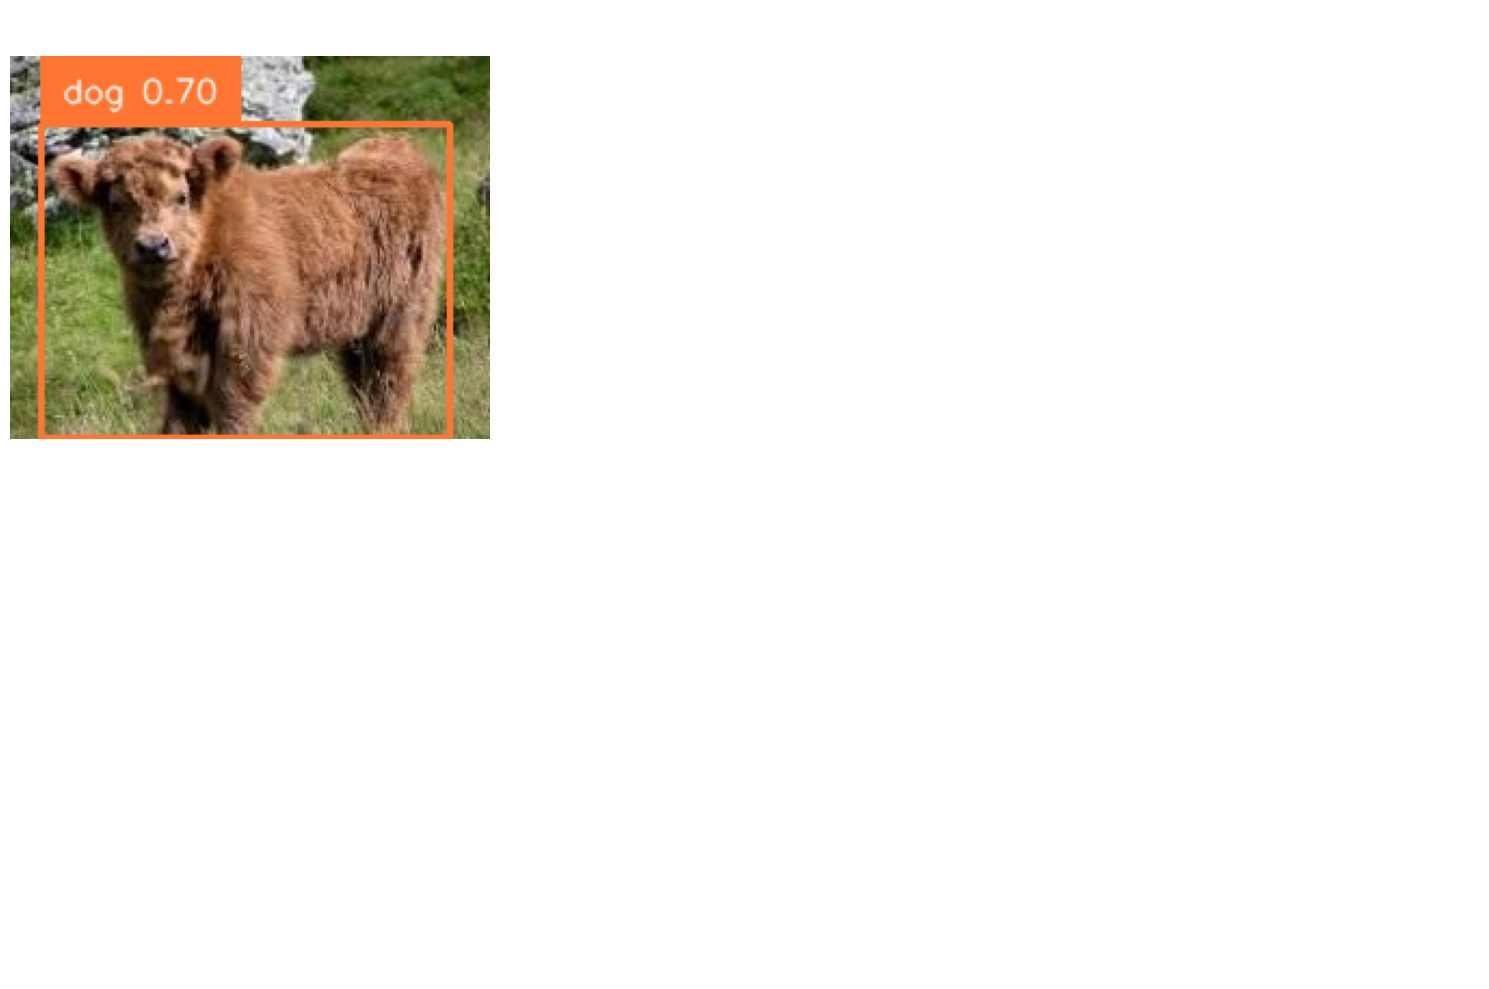

In [ ]:
#Visualize Predicition
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import supervision as sv

CLASS_NAMES = [
    "cat", "chicken", "cow", "dog", "fox", "goat", "horse", "person", "raccoon", "skunk"
]

TEST_DIR = "/content/animals-2/test/"
NUM_IMAGES = 1

image_paths = [
    os.path.join(TEST_DIR, f)
    for f in os.listdir(TEST_DIR)
    if f.lower().endswith((".jpg", ".png"))
]
sampled = random.sample(image_paths, NUM_IMAGES)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, path in enumerate(sampled):
    img = Image.open(path).convert("RGB")
    detections = model.predict(img, threshold=0.4)

    valid = [
        j for j, cls in enumerate(detections.class_id)
        if 0 <= cls < len(CLASS_NAMES)
    ]

    if valid:
        detections.class_id = [detections.class_id[j] for j in valid]
        detections.confidence = [detections.confidence[j] for j in valid]
        detections.xyxy = np.array([detections.xyxy[j] for j in valid])
        labels = [f"{CLASS_NAMES[cls]} {conf:.2f}" for cls, conf in zip(detections.class_id, detections.confidence)]

        img = sv.BoxAnnotator().annotate(img.copy(), detections)
        img = sv.LabelAnnotator().annotate(img, detections, labels)

    axes[i].imshow(img)
    axes[i].axis("off")

for j in range(NUM_IMAGES, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


**EVALUATION**

In [ ]:
coco_json_path = "/content/animals-2/test/_annotations.coco.json"

In [ ]:
from pycocotools.coco import COCO
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
import json
import os

def generate_coco_predictions(model, image_dir, ann_file, output_json_path, device='cpu'):
    model.eval()
    model.to(device)

    coco = COCO(ann_file)
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    results = []

    for img_id in tqdm(coco.imgs):
        img_info = coco.loadImgs(img_id)[0]
        file_path = os.path.join(image_dir, img_info['file_name'])
        image = Image.open(file_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(image_tensor)  # <--- use model(image_tensor) instead of model.predict()

        for box, score, label in zip(outputs[0]['boxes'], outputs[0]['scores'], outputs[0]['labels']):
            x1, y1, x2, y2 = box.tolist()
            width = x2 - x1
            height = y2 - y1
            results.append({
                "image_id": img_id,
                "category_id": int(label),
                "bbox": [x1, y1, width, height],
                "score": float(score)
            })

    with open(output_json_path, 'w') as f:
        json.dump(results, f)

    print(f"Predictions saved to {output_json_path}")

In [ ]:
generate_coco_predictions(
    model=model,
    image_dir="/content/animals-2/test",
    ann_file="/content/animals-2/test/_annotations.coco.json",
    output_json_path="rfdetr_predictions.json"
)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 100/100 [00:00<00:00, 1017.69it/s]

Predictions saved to rfdetr_predictions.json


In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json

# Load ground truth
coco_gt = COCO("/content/animals-2/test/_annotations.coco.json")

# Load model predictions
coco_dt = coco_gt.loadRes("rfdetr_predictions.json")

# Initialize COCOeval
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')

# Run evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


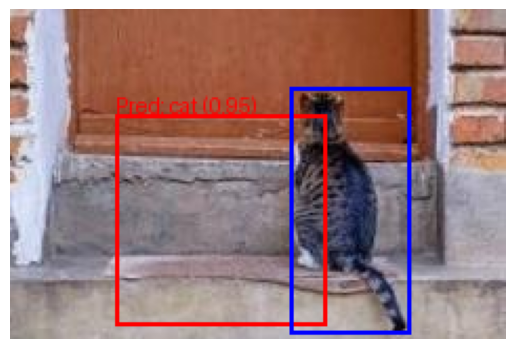

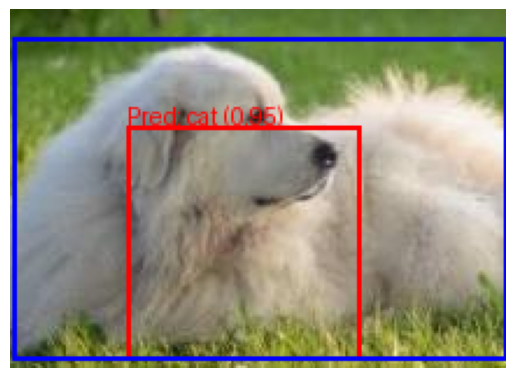

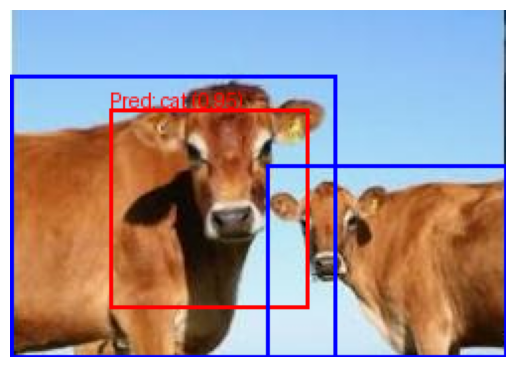

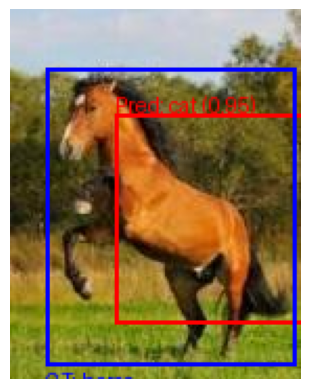

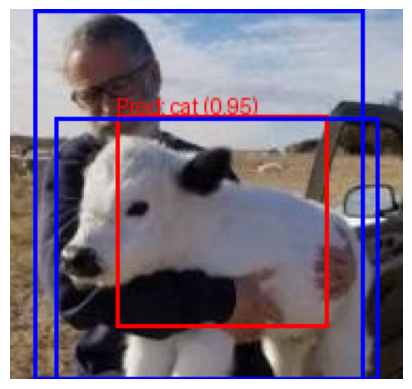

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import json
import os
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from collections import defaultdict

# Load predictions
with open("rfdetr_predictions.json") as f:
    predictions = json.load(f)

# Group predictions by image
preds_by_image = defaultdict(list)
for pred in predictions:
    preds_by_image[pred["image_id"]].append(pred)

# Load COCO ground truth
ann_file = "/content/animals-2/test/_annotations.coco.json"
coco = COCO(ann_file)
cat_id_to_name = {cat['id']: cat['name'] for cat in coco.loadCats(coco.getCatIds())}
img_info = coco.loadImgs(coco.getImgIds())

# Optional font
try:
    font = ImageFont.truetype("arial.ttf", 14)
except:
    font = ImageFont.load_default()

# Draw 5 samples
for img in img_info[:5]:
    img_path = os.path.join("/content/animals-2/test", img["file_name"])
    image = Image.open(img_path).convert("RGB")
    draw = ImageDraw.Draw(image)

    # Draw predicted boxes in RED with labels
    for pred in preds_by_image[img["id"]]:
        x, y, w, h = pred["bbox"]
        label = pred.get("category_id", "")
        score = pred.get("score", 0)
        name = cat_id_to_name.get(label, str(label))
        draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
        draw.text((x, y - 10), f"Pred: {name} ({score:.2f})", fill="red", font=font)

    # Draw ground truth boxes in BLUE with labels
    ann_ids = coco.getAnnIds(imgIds=img["id"])
    anns = coco.loadAnns(ann_ids)
    for ann in anns:
        x, y, w, h = ann["bbox"]
        name = cat_id_to_name.get(ann["category_id"], str(ann["category_id"]))
        draw.rectangle([x, y, x + w, y + h], outline="blue", width=2)
        draw.text((x, y + h + 2), f"GT: {name}", fill="blue", font=font)

    # Show the result
    plt.imshow(image)
    plt.axis("off")
    plt.show()